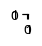

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [4]:
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')

In [14]:
# This is the swapped dataset
b = pd.read_csv('../data/NetTCR/nettcr_train_mathias_with_swaps.csv')
b.to_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv', index=False)

In [2]:
def encode_cat(sequence, max_len):
    return F.pad(torch.tensor([CHAR_TO_INT[x] for x in sequence]), (0, max_len-(len(sequence))), value=-1)

def batch_encode_cat(sequences, max_len):
    return torch.stack([encode_cat(x, max_len) for x in sequences])

In [4]:
from src.data_processing import encode_batch, CHAR_TO_INT
from src.models import FullTCRVAE
from src.datasets import TCRpMHCDataset, TCRSpecificDataset
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
model = FullTCRVAE(0, 0, 22, 0, 0, 23, 'BL50LO', hidden_dim=128, latent_dim=64)
model = load_checkpoint(model, '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt')
model.eval()
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')

dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')

with torch.no_grad():
    z_embed = model.embed(dataset.x)
encoded_peps = batch_encode_cat(df['peptide'], 12)

Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [5]:
z=torch.normal(torch.tensor([-0.05]*10), torch.tensor([2]*10))
F.sigmoid(z), z

(tensor([0.7376, 0.8379, 0.4941, 0.4256, 0.0361, 0.0307, 0.0446, 0.1592, 0.2854,
         0.4761]),
 tensor([ 1.0333,  1.6430, -0.0234, -0.2998, -3.2851, -3.4526, -3.0650, -1.6641,
         -0.9176, -0.0956]))

In [8]:
from src.torch_utils import load_model_full
ckpt = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt'
js = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json'
model = load_model_full(ckpt, js)


Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [13]:
args = {'folder': '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/'}
checkpoint_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.pt'), os.listdir(args['folder'])))
json_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.json'), os.listdir(args['folder'])))

In [15]:
checkpoint_file,  json_file

('checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt',
 'checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json')

In [11]:
n_layers=1
for _ in range(n_layers-1):
    print('xd')

In [9]:
model

FullTCRVAE(
  (encoder): Sequential(
    (0): Linear(in_features=900, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=64, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=900, bias=True)
  )
)

# results comparison 

Using various VAEs with A3-B3, with or without triplet loss
- NH 50
- dropout 0.25
- BatchNorm
- 1 in_layer, 1 hidden layer, 1 out_layer (n_latent+pep_dim -> n_hidden -> n_hidden -> n_out (1))
- 1000 epochs

In [51]:
import glob

['../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_4_231206_1319_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_1_231206_1302_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_3_231206_1313_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_0_231206_1257_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_2_231206_1308_Ds1PC']

In [71]:
peporder = df.query('binder==1').groupby('peptide').agg(count=('B3', 'count')).sort_values('count', ascending=False)
peporder, count = peporder.index, peporder.values

In [79]:
name = f.split('Swaps_')[1].split('_KFold')[0]
name

'Cos_25k_AutoSmall'

In [101]:
from src.metrics import get_metrics
# Get predictions per peptide, hue by model -> do a scatter plot of 5 folds?

def get_per_pep_fold_metrics(d):
    results = []
    for i, f in enumerate(sorted(glob.glob(d+'/*'))):
        name = f.split('Swaps_')[1].split('_KFold')[0]
        run_id = f.split('_')[-1]
        pf = next(filter(lambda x:'pred' in x and x.endswith('.csv'), os.listdir(f)))
        
        preds = pd.read_csv(f+'/'+pf)
        for pep in peporder:
            tmp = preds.query('peptide==@pep')
            res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
            metrics = get_metrics(tmp['binder'], tmp['pred_prob'])
            res.update(metrics)
            results.append(res)
    return pd.DataFrame(results)

In [102]:
dirs = glob.glob('../output/classifier_results/*')
clfs = pd.concat([get_per_pep_fold_metrics(d) for d in dirs])

In [105]:
clfs.groupby(['peptide','name']).agg(mean_auc=('auc','mean'), mean_auc01=('auc_01','mean'), mean_prec = ('precision','mean'))

mean_auc  mean_auc01  mean_prec
peptide   name                                                 
ATDALMTGF Cos_10k_Auto           0.68862     0.54916    0.10000
          Cos_25k_01Large        0.72734     0.54718    0.10000
          Cos_25k_AutoSmall      0.70900     0.60234    0.20000
          L2_10k_Auto            0.73404     0.55354    0.00000
          L2_25k_15Large         0.67864     0.53700    0.00000
...                                  ...         ...        ...
YLQPRTFLL L2_25k_15Large         0.85106     0.72114    0.37142
          L2_25k_AutoSmall       0.74774     0.70488    0.40000
          NoTrp_10k_Small        0.79588     0.72652    0.96666
          Old_25k_HiKLD_Large    0.76640     0.67030    0.74286
          Old_25k_LowKLD_Large   0.78572     0.68590    0.75000

[234 rows x 3 columns]

In [127]:
top10pep = peporder[:10]
sns.barplot(data=clfs, x='peptide', hue='name', y='auc')
clfs.reset_index()

,index,name,run_id,fold,peptide,auc,auc_01,auc_01_real,precision,accuracy,AP
0,0,NoTrp_10k_Small,BeIgZ,0,GILGFVFTL,0.7954,0.6987,0.4276,0.7551,0.8626,0.5799
1,1,NoTrp_10k_Small,BeIgZ,0,RAKFKQLL,0.7786,0.6695,0.3720,0.8000,0.8653,0.5372
2,2,NoTrp_10k_Small,BeIgZ,0,KLGGALQAK,0.6214,0.5162,0.0807,0.0000,0.8336,0.2269
3,3,NoTrp_10k_Small,BeIgZ,0,AVFDRKSDAK,0.6248,0.5235,0.0946,0.0000,0.8326,0.2385
4,4,NoTrp_10k_Small,BeIgZ,0,ELAGIGILTV,0.7872,0.6111,0.2612,0.7778,0.8418,0.4597
...,...,...,...,...,...,...,...,...,...,...,...
1165,125,L2_25k_AutoSmall,V0dKW,4,SLFNTVATLY,0.4342,0.4737,0.0000,0.0000,0.8261,0.1617
1166,126,L2_25k_AutoSmall,V0dKW,4,RPPIFIRRL,0.7083,0.5066,0.0625,0.0000,0.8182,0.3199
1167,127,L2_25k_AutoSmall,V0dKW,4,FEDLRLLSF,0.5115,0.5246,0.0968,0.0000,0.8158,0.2409
1168,128,L2_25k_AutoSmall,V0dKW,4,VLFGLGFAI,0.9161,0.8947,0.8000,0.0000,0.8611,0.8556


In [139]:
clfs.groupby('name').auc.mean()

name
Cos_10k_Auto            0.655610
Cos_25k_01Large         0.673506
Cos_25k_AutoSmall       0.660439
L2_10k_Auto             0.660068
L2_25k_15Large          0.659089
L2_25k_AutoSmall        0.652827
NoTrp_10k_Small         0.667255
Old_25k_HiKLD_Large     0.663066
Old_25k_LowKLD_Large    0.679568
Name: auc, dtype: float64

In [147]:
clfs.query('name=="Cos_25k_01Large" and peptide == "ATDALMTGF"').auc.std()

0.05099218567584645

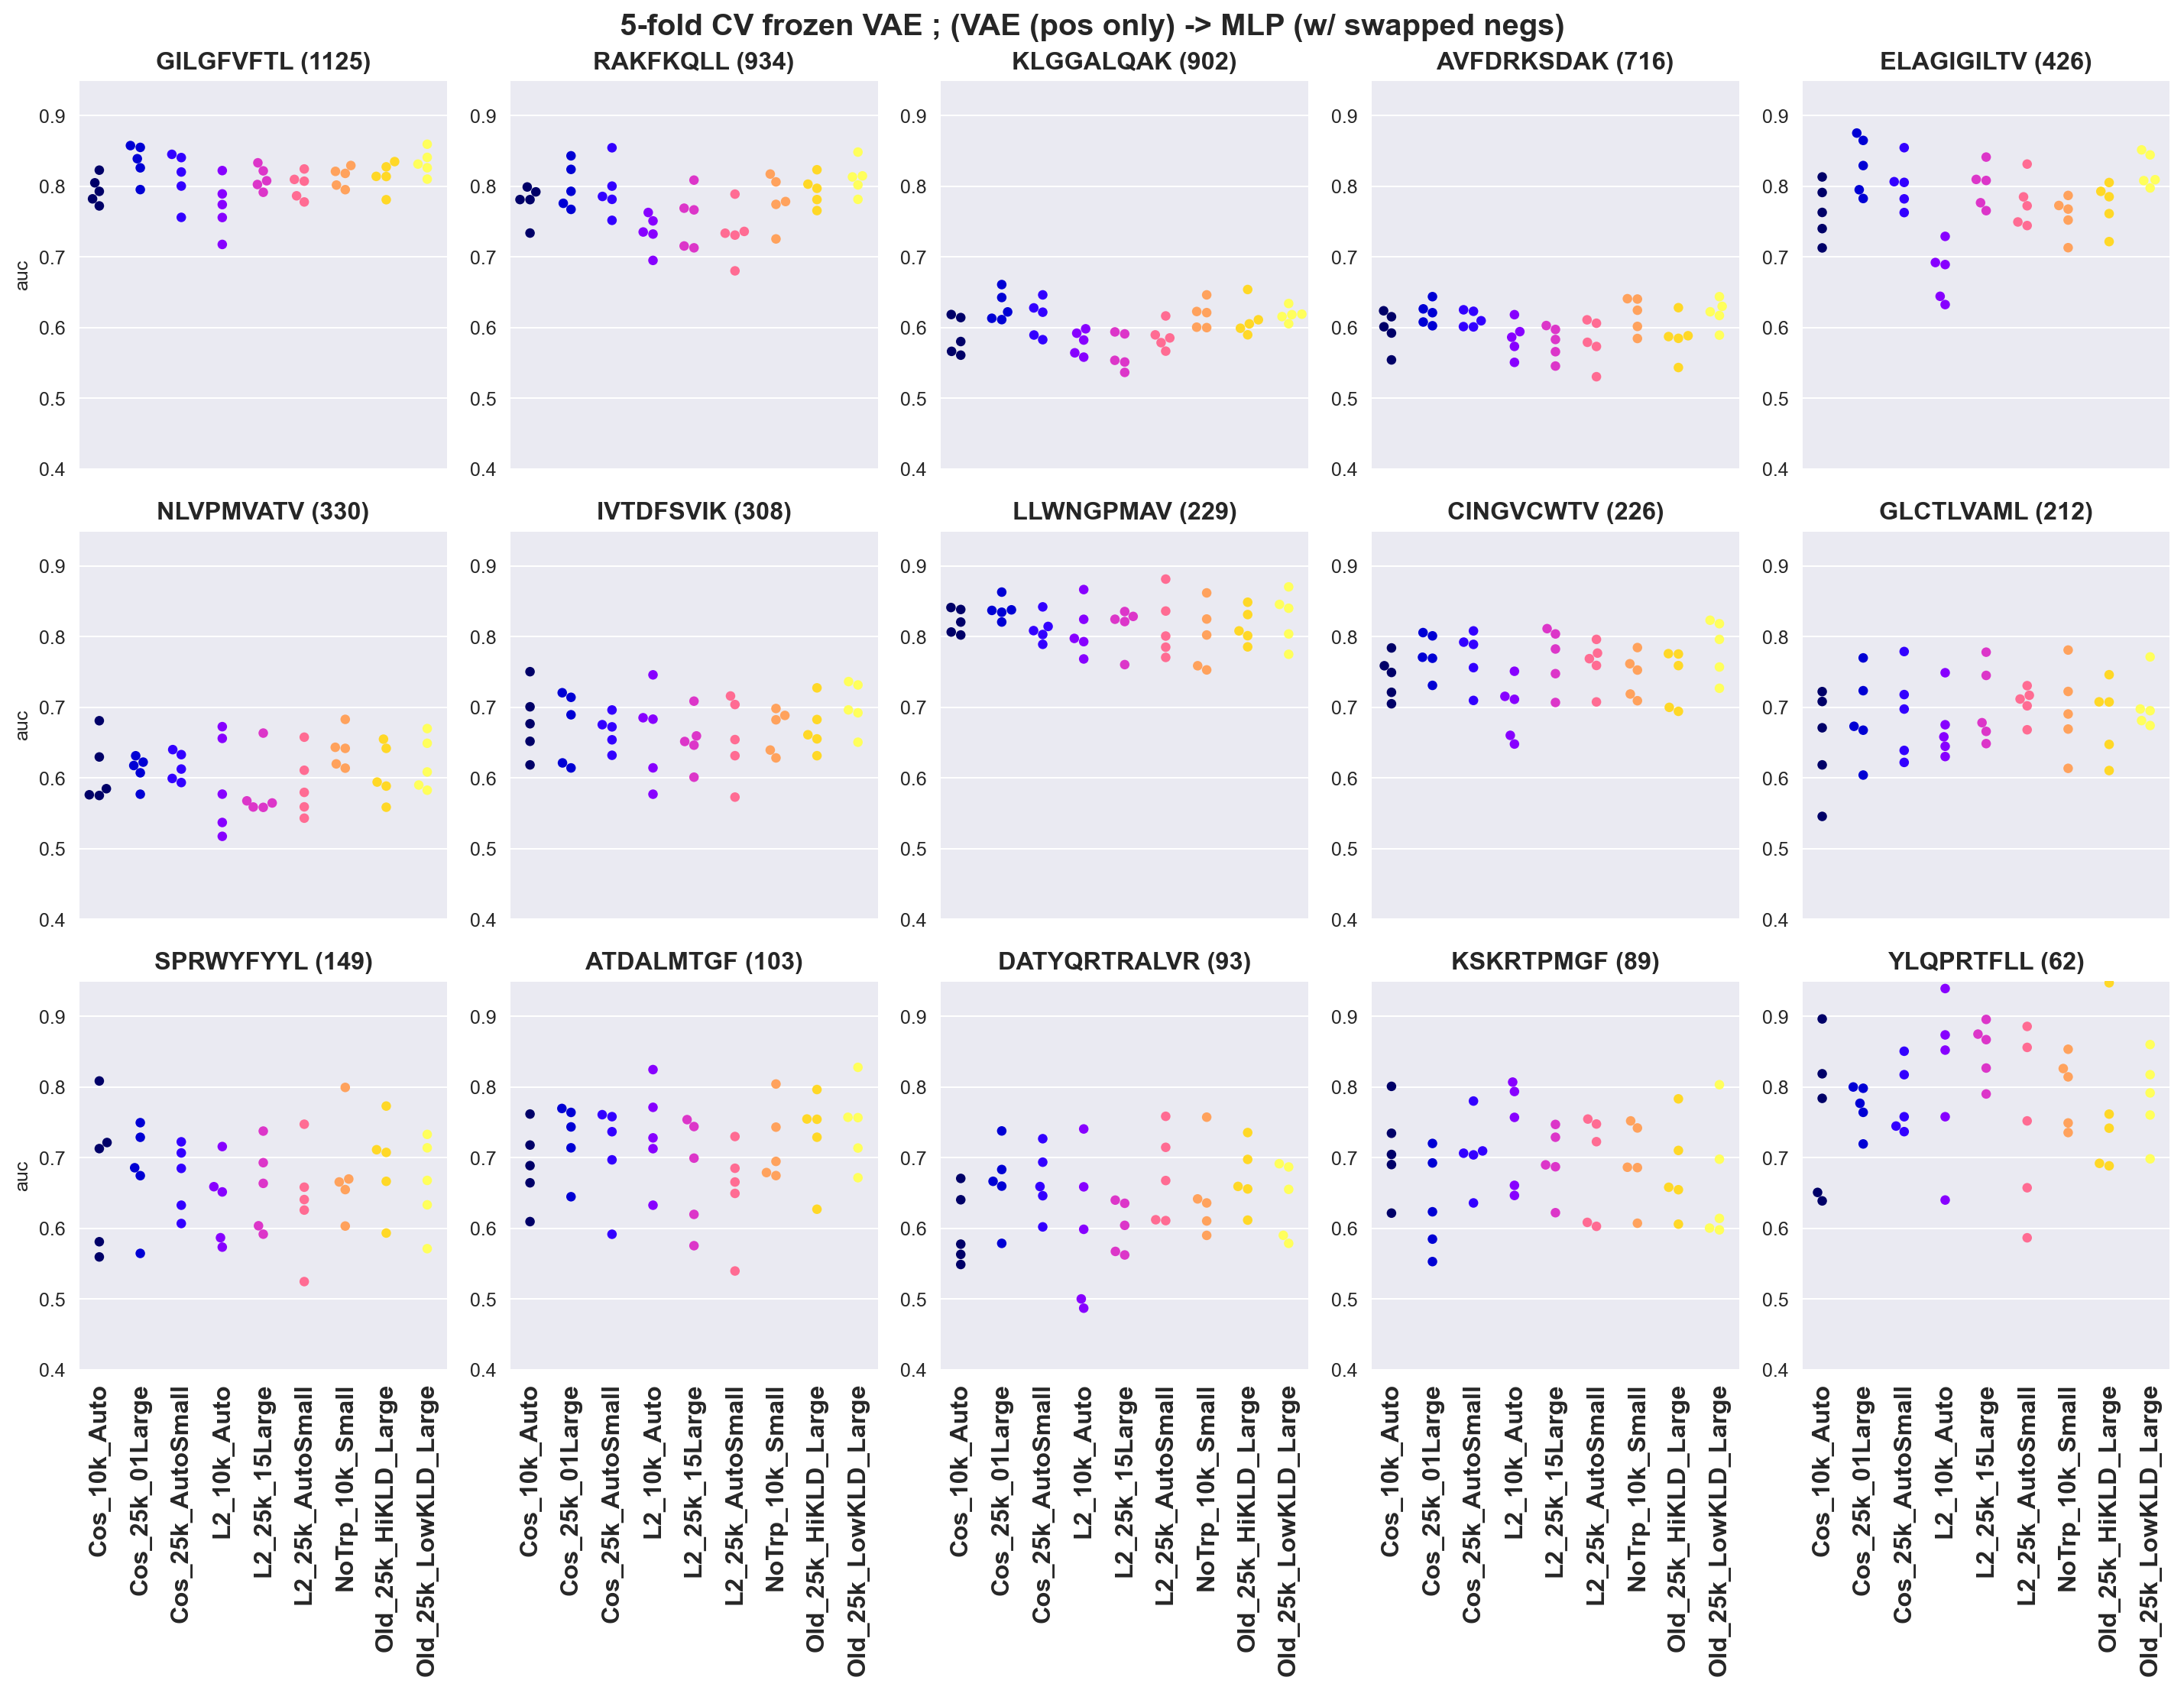

In [171]:
sns.set_palette(get_palette('gnuplot2', 9))
f,a = plt.subplots(3, 5, figsize=(16,12.5), sharex=True)
a = a.ravel()
order = sorted(clfs.name.unique())
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = clfs.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs)', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

In [172]:
clfs.query('peptide in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False) * 100

,mean_auc,std_auc,max_auc,mean_auc01,std_auc01,max_auc01
name,,,,,,
Old_25k_LowKLD_Large,73.4542,9.233846,87.06,63.3078,8.880963,77.97
Cos_25k_01Large,73.0204,9.621670,87.55,63.1108,9.230493,76.77
Cos_25k_AutoSmall,71.9248,8.966130,85.48,62.1646,8.396706,75.85
NoTrp_10k_Small,71.3934,7.849412,86.21,61.0524,7.173874,74.88
Old_25k_HiKLD_Large,71.0082,9.076092,84.89,61.6092,8.100765,75.05
L2_25k_15Large,70.3620,10.240707,84.15,61.8416,8.017798,74.86
Cos_10k_Auto,70.3154,9.136301,84.14,61.0066,7.820708,75.31
L2_25k_AutoSmall,70.0930,9.375966,88.16,61.2800,7.976524,73.84
L2_10k_Auto,67.8214,8.539488,86.68,58.7072,7.073152,76.76


In [174]:
clfs.query('peptide not in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False) * 100

,mean_auc,std_auc,max_auc,mean_auc01,std_auc01,max_auc01
name,,,,,,
L2_10k_Auto,64.872750,13.197475,93.95,55.187500,7.442196,80.62
Old_25k_LowKLD_Large,64.521000,12.107078,89.25,54.469125,7.631945,80.26
NoTrp_10k_Small,63.808125,13.932679,90.86,55.771875,7.613104,81.75
Cos_25k_01Large,63.807000,9.751978,81.11,54.435500,6.492766,80.86
Old_25k_HiKLD_Large,63.368125,12.686419,94.76,54.659125,7.143874,81.32
L2_25k_15Large,63.125750,12.963870,94.62,55.498000,8.891046,85.57
Cos_10k_Auto,62.589500,12.479911,89.65,55.314375,7.245211,82.60
Cos_25k_AutoSmall,62.368375,11.331247,85.08,54.465500,6.942705,84.01
L2_25k_AutoSmall,62.276250,14.029960,91.61,55.992500,8.214624,89.47


In [175]:
clfs.groupby(['name']).agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std')).sort_values('mean_auc',ascending=False)

,mean_auc,std_auc,mean_auc01,std_auc01
name,,,,
Old_25k_LowKLD_Large,0.679568,0.118823,0.578686,0.091795
Cos_25k_01Large,0.673506,0.106608,0.577722,0.087253
NoTrp_10k_Small,0.667255,0.124903,0.578028,0.078545
Old_25k_HiKLD_Large,0.663066,0.119907,0.573322,0.082281
Cos_25k_AutoSmall,0.660439,0.114433,0.574267,0.083927
L2_10k_Auto,0.660068,0.116806,0.565412,0.074751
L2_25k_15Large,0.659089,0.124598,0.579378,0.090790
Cos_10k_Auto,0.655610,0.118880,0.575037,0.079441
L2_25k_AutoSmall,0.652827,0.129812,0.580262,0.084948
